In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import spacy
import nltk
import string
from bs4 import BeautifulSoup
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans

In [2]:
%store -r python_questions
%store -r qns_with_code
%store -r sample
%store -r sample_text
%store -r dtm
%store -r dtm_df
%store -r dtm_tsne
%store -r dtm_tsne_df

In [3]:
ENGLISH_STOP_WORDS = [
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself",
    "yourselves", "thanks", "able", "", "a", "b", "c", "d", "e", "f", "g",
    "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v",
    "w", "x", "y", "z", "use", "work", "python", "want", "way", "try"]

nlp = spacy.load("en")

In [4]:
def plot_score_title_body_length(df):
    questions_title_length = df["Title"].apply(lambda x: len(x))
    questions_body_length = df["Body"].apply(lambda x: len(x))
    fig, ax = plt.subplots(ncols=3, nrows=1)
    fig.set_size_inches(11.7, 4)
    sns.distplot(df[df.Score <= 50].Score, ax=ax[0], color="#074484")
    sns.distplot(questions_title_length, ax=ax[1], color="#074484")
    sns.distplot(questions_body_length[questions_body_length < 10000], ax=ax[2], color="#074484")
    
def plot_score_body_length(df):
    body_length = df["Body"].apply(lambda x: len(x))
    fig, ax = plt.subplots(ncols=2, nrows=1)
    fig.set_size_inches(11.7, 4)
    sns.distplot(df[df.Score <= 50].Score, ax=ax[0], color="#074484")
    sns.distplot(body_length[body_length < 10000], ax=ax[1], color="#074484")

def sampling_clean_text(df, num_of_samples):
    def return_code_body(text):
        pattern = re.compile(r'<[^>]+>|\n|\r')
        soup = BeautifulSoup(text, 'html.parser')
        return pattern.sub(" ", str(soup.pre))
    test_code = df.sample(n=num_of_samples)
    test_code["Code Body"] = test_code["Body"].apply(lambda x: return_code_body(x))
    test_code["Body Exc. Code"] = test_code["Body"].str.replace(r'<pre>([a]|[^a])+</pre>'," ").str.replace(r"<[^>]+>|\n|\r", " ")
    test_code["Body + Title"] = test_code["Title"] + " " + test_code["Body Exc. Code"]
    test_code.drop(["Title", "Body", "Body Exc. Code"], inplace=True, axis=1)
    test_code["Full Body"] = test_code["Body + Title"] + " " + test_code["Code Body"]
    return test_code

def get_clusters(X, index, n_cluster, batch_size=200, series_name='clusters'):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = MiniBatchKMeans(n_clusters=n_cluster, batch_size=batch_size, random_state=0).fit(X) 
        return pd.Series(model.labels_, index=index, name=series_name)
    
def find_top_n_import(df, n):
    pattern = re.compile(r'(from\s([^\s]+)\simport\s([^\s]+)|import\s([^\s]+))')
    sample_text_import = df["Code Body"].str.extractall(pattern)[0]
    sample_text_import_count = sample_text_import.value_counts()
    sample_text_import_count_df = pd.DataFrame(sample_text_import_count, index=sample_text_import_count.index, columns=["Count"])
    sns.barplot(y=sample_text_import_count_df.iloc[0:n].index,
            x=sample_text_import_count_df.iloc[0:n].Count, 
            data=sample_text_import_count_df.iloc[0:n],
            color="#074484")

def tokenize(text):
    text = "".join([ch for ch in text if ((ch not in string.punctuation) & (ch not in "âÂ0123456789") & (ch != ""))])
    doc = nlp(text)
    tokens = []
    for token in doc:
        if (" " not in token.lemma_) & ("    " not in token.lemma_): tokens.append(token.lemma_)
    return tokens

def get_tsne(dtm, dtm_df):
    tsne = TSNE(n_components=2, random_state=0)
    if dtm_df.shape[1] <= 10000:
        dtm_tsne = tsne.fit_transform(dtm.toarray())
    else:
        n_components_pca = 10000
        dtm_tsne = tsne.fit_transform(PCA(n_components=n_components_pca, random_state=0).fit_transform(dtm.toarray()))
    return dtm_tsne

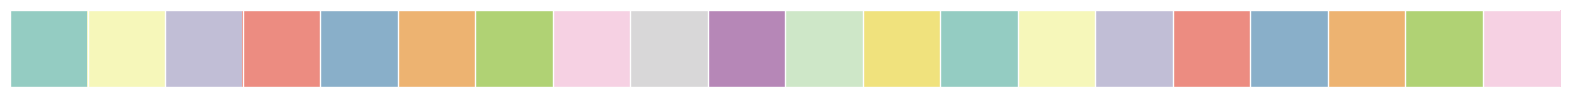

In [5]:
sns.palplot(sns.color_palette("Set3", n_colors=20, desat=.8))
sns.set_palette("Set3", n_colors=20, desat=.8)

# Data Exploration

In [5]:
#python_questions = pd.read_csv("./pythonquestions/Questions.csv", encoding = "latin1")

In [6]:
#python_questions["CreationDate"] = python_questions["CreationDate"].apply(lambda x: pd.to_datetime(x))
#python_questions["Title"] = python_questions["Title"].apply(lambda x: str(x))
#python_questions["Body"] = python_questions["Body"].apply(lambda x: str(x))

In [7]:
#python_questions.set_index("Id", inplace=True)

In [8]:
python_questions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 602869 entries, 203487 to 40043149
Data columns (total 5 columns):
OwnerUserId     596699 non-null float64
CreationDate    602869 non-null datetime64[ns]
Score           602869 non-null int64
Title           602869 non-null object
Body            602869 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 27.6+ MB


In [9]:
#python_questions = python_questions[(python_questions["CreationDate"] > "2008-10-14 23:59:59") & (python_questions["CreationDate"] < "2016-10-13 00:00:00")]
python_questions.head(5)

,OwnerUserId,CreationDate,Score,Title,Body
Id,,,,,
203487,5646.0,2008-10-15 02:00:27,19,Creating self-contained python applications,<p>I'm trying to create a self-contained versi...
203758,115.0,2008-10-15 04:55:33,2,Receive socket size limits good?,<p>I am writing a program in Python that will ...
203859,432.0,2008-10-15 06:22:22,2,"How do I get python-markdown to additionally ""...",<p>Markdown is a great tool for formatting pla...
203912,20211.0,2008-10-15 06:59:50,60,Does python support multiprocessor/multicore p...,<p>What is the difference between multiprocess...
204017,267.0,2008-10-15 08:24:28,206,How do I execute a program from python? os.sys...,<p>I have a python script that needs to execut...


/Users/apple/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


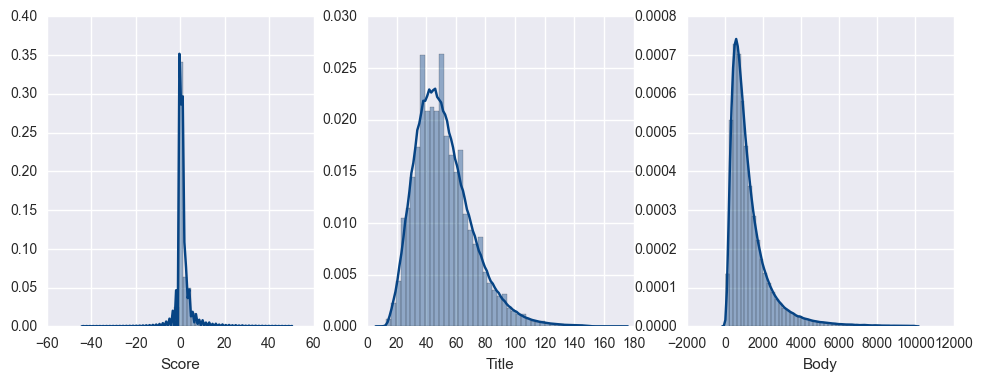

In [10]:
plot_score_title_body_length(python_questions)

In [11]:
python_questions[python_questions["Body"].apply(lambda x:len(x) > 3000)].sample(n=5)

,OwnerUserId,CreationDate,Score,Title,Body
Id,,,,,
37594540,6345031.0,2016-06-02 14:20:13,1,passing textures to GLSL,<p>I'm trying to read a texture in a shader. A...
8452285,469682.0,2011-12-09 22:05:33,0,UnicodeDecodeError: 'ascii' codec can't decode...,"<p>I'm trying to post some data to a url, but ..."
11713933,214812.0,2012-07-29 23:47:41,5,Homework - Python Proxy Server,<p>For a programming exercise (<strong>from Co...
38644150,4333220.0,2016-07-28 18:28:55,3,Create a bar graph using datetimes,<p>I am using matplotlib and pyplot to create ...
8637894,690204.0,2011-12-26 17:40:19,0,sqlalchemy UnicodeDecodeError: 'utf8' codec ca...,<p>I'm building an application that works with...


In [12]:
#qns_with_code = python_questions[python_questions["Body"].apply(lambda text: '<pre>' in text)]
qns_with_code.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 483535 entries, 204017 to 40043149
Data columns (total 5 columns):
OwnerUserId     478824 non-null float64
CreationDate    483535 non-null datetime64[ns]
Score           483535 non-null int64
Title           483535 non-null object
Body            483535 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 22.1+ MB


/Users/apple/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


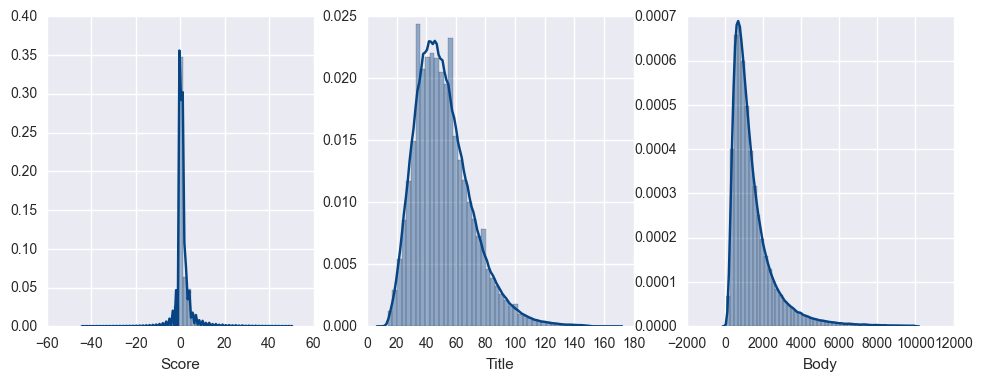

In [13]:
plot_score_title_body_length(qns_with_code)

# Trial Stage

In [14]:
vect = TfidfVectorizer(max_df=0.8, max_features=200000,
                       min_df=0.1, stop_words='english', ngram_range=(1,3),
                       analyzer='word')

In [15]:
#sample = sampling_clean_text(qns_with_code,10000)
sample.head()

,OwnerUserId,CreationDate,Score,Title,Code Body,Body Exc. Code
Id,,,,,,
31800715,4975789.0,2015-08-04 04:28:15,3,Python dataframe turn click path row to column,"df = pd.DataFrame({'id':[1, 1, 1, 2, 2], 'm'...",I have a Python Pandas dataFrame like below: ...
26323418,2517015.0,2014-10-12 08:54:11,0,Python Whoosh AttributeError when updating index,from search import update_index @view_confi...,I'm trying to update my whoosh search index w...
15010556,1474895.0,2013-02-21 19:23:43,1,Python Bottle Issues when Accessed Externally,"from bottle import route, get, post, request...",So I am using the bottle module for python to...
39946614,1107049.0,2016-10-09 17:45:43,1,How to Convert to Seconds from Data Time using...,`value = '12/30/99 00:00:55 AM'` `duration =...,I have a data CSV file where the Time Duratio...
27048467,4228603.0,2014-11-20 20:03:07,-1,Finding alternating sum in python,"def altsum_digits(n,d): sum = 0 my_n...",i'm trying to write a code finding the altern...


In [16]:
#sample_text = sample[["Title", "Code Body", "Body Exc. Code"]]
sample_text.head(5)

,Title,Code Body,Body Exc. Code
Id,,,
31800715,Python dataframe turn click path row to column,"df = pd.DataFrame({'id':[1, 1, 1, 2, 2], 'm'...",I have a Python Pandas dataFrame like below: ...
26323418,Python Whoosh AttributeError when updating index,from search import update_index @view_confi...,I'm trying to update my whoosh search index w...
15010556,Python Bottle Issues when Accessed Externally,"from bottle import route, get, post, request...",So I am using the bottle module for python to...
39946614,How to Convert to Seconds from Data Time using...,`value = '12/30/99 00:00:55 AM'` `duration =...,I have a data CSV file where the Time Duratio...
27048467,Finding alternating sum in python,"def altsum_digits(n,d): sum = 0 my_n...",i'm trying to write a code finding the altern...


In [17]:
#dtm = vect.fit_transform(sample_text["Body Exc. Code"])
dtm.shape

(10000, 25)

In [18]:
#dtm_df = pd.DataFrame(dtm.toarray(), columns=vect.get_feature_names())
dtm_df.head(5)

,code,data,does,error,example,file,following,function,help,just,...,python,thanks,tried,trying,use,using,ve,want,way,work
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.460356,0.695382,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.754774,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.655985,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.220404,0.000000,0.345447,0.600443,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.209819,0.000000,0.0,0.000000,0.292765,0.237664,0.336064,0.0,0.0,0.0
3,0.000000,0.467766,0.000000,0.000000,0.000000,0.418822,0.0,0.0,0.000000,0.000000,...,0.304312,0.000000,0.0,0.000000,0.424612,0.344697,0.000000,0.0,0.0,0.0
4,0.208237,0.000000,0.000000,0.000000,0.300715,0.000000,0.0,0.0,0.293239,0.301776,...,0.000000,0.299442,0.0,0.246523,0.000000,0.000000,0.317512,0.0,0.0,0.0


In [19]:
tsne = TSNE(n_components=2, random_state=0)
#if dtm_df.shape[1] <= 10000:
    #dtm_tsne = tsne.fit_transform(dtm.toarray())
#else:
    #n_components_pca = 10000
    #dtm_tsne = tsne.fit_transform(PCA(n_components=n_components_pca, random_state=0).fit_transform(dtm.toarray()))

In [20]:
#dtm_tsne_df = pd.DataFrame(dtm_tsne, index=sample_text.index, columns=['x', 'y'])
dtm_tsne_df.head(5)

,x,y,Cluster
Id,,,
31800715,-6.384696,-2.977865,4
26323418,-1.016236,-3.332309,6
15010556,1.558119,-3.557842,6
39946614,2.016370,0.437977,5
27048467,6.699470,3.404037,7


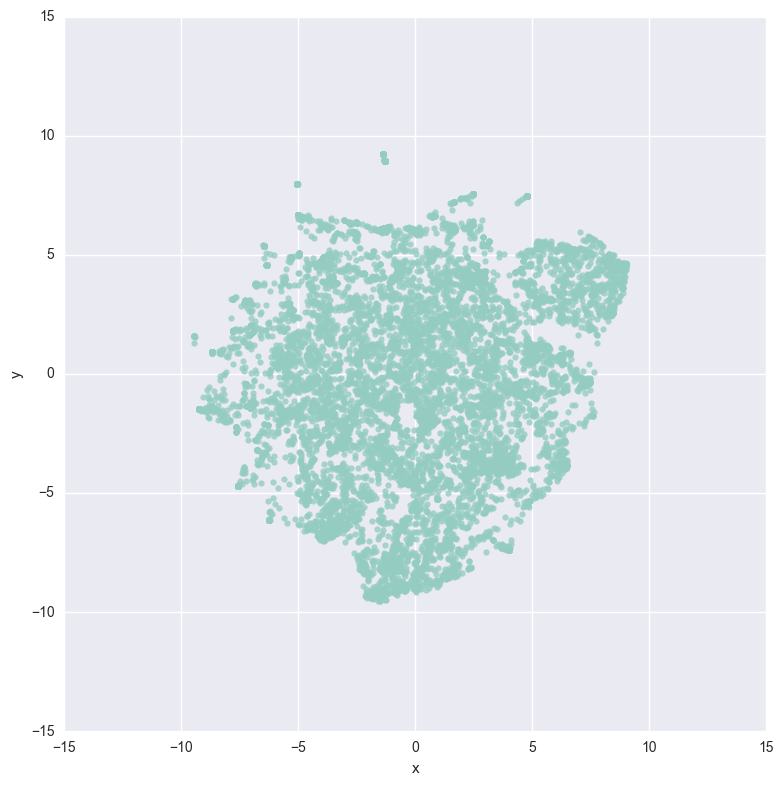

In [21]:
sns.lmplot("x", "y", data=dtm_tsne_df, fit_reg=False, aspect=1.0, size=8)

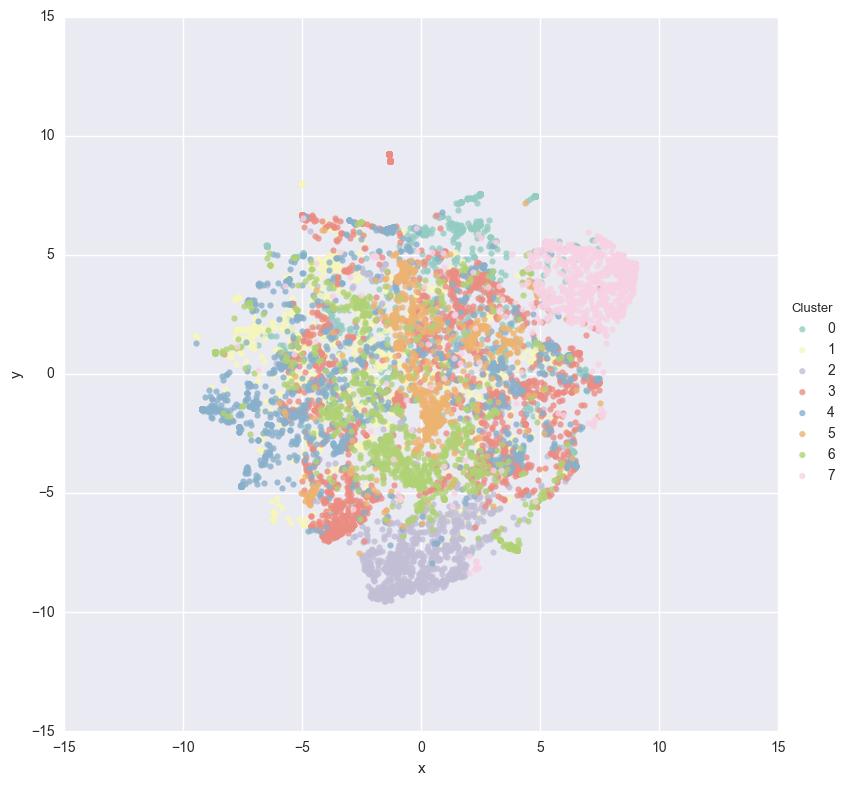

In [22]:
#clusters = get_clusters(dtm, sample_text.index, 8)
#dtm_tsne_df["Cluster"] = clusters
sns.lmplot("x", "y", hue="Cluster", data=dtm_tsne_df, fit_reg=False, aspect=1.0, size=8)

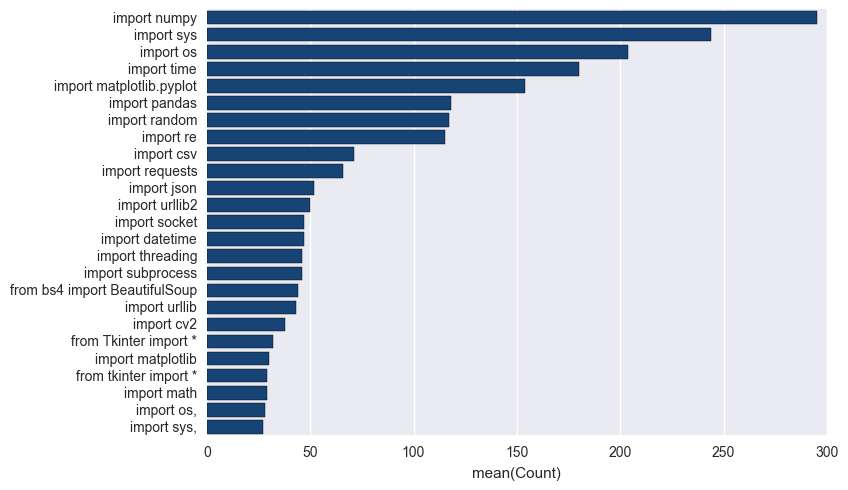

In [23]:
find_top_n_import(sample_text, 25)

# Reconstruct Vectorizer 

In [6]:
sample_text_new = sampling_clean_text(python_questions, 3000)

In [7]:
sample_text_new.head(2)

,OwnerUserId,CreationDate,Score,Code Body,Body + Title,Full Body
Id,,,,,,
3666328,243780.0,2010-09-08 09:31:16,3,None,Can I get SQLite to string instead of unicode ...,Can I get SQLite to string instead of unicode ...
23350294,1800861.0,2014-04-28 20:10:32,0,1. 57.00057 2. 611.000000611 3. 389.0000...,Checking number patterns in Python How can I ...,Checking number patterns in Python How can I ...


In [8]:
vect_idf = TfidfVectorizer(min_df=0.05, max_df=0.8, stop_words=ENGLISH_STOP_WORDS, ngram_range=(1,2), tokenizer=tokenize)

In [9]:
rand_index = np.random.randint(0, sample_text_new.shape[0])
print("Current index: %.d" % rand_index)
print(sample_text_new["Full Body"].iloc[rand_index])
print(tokenize(sample_text_new["Full Body"].iloc[rand_index]))

Current index: 2301
Create users on Microsoft Active Directory using a Scripting Language  I need to create and/or update the Students users in the school I work in. I only have access to the "Remote Control" not directly on the server and I have been told, that I will be able to remotely create, update and delete users and groups.    The problem is: I must create a lot users every 1/2 Year and so, I want to do that automatically. I have a database dump from the students and the classes so I could read that out in a scripting language like Python, PHP or in a Java/C++ program (Python would be my favourite)    I am looking for a way to create the groups and the users with a scripting lanugage on a remote computer and if it also works I want to create sharedrives and give the users/groups access to that automatically.    Each half year, the users get updated in the new class so I must fetch a record of the users and check it against the new students list and update the users.    Does any

In [10]:
dtm_idf = vect_idf.fit_transform(sample_text_new["Full Body"])

In [11]:
count_idf = pd.DataFrame(dtm_idf.toarray(), columns=vect_idf.get_feature_names())
count_idf.head(3)

,access,add,app,application,appreciate,array,base,case,change,check,...,true,type,url,user,value,variable,version,window,write,wrong
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.403374,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.205023,0.0,0.0,0.411403,0.0,0.0,0.0,0.0,0.185598,0.000000,...,0.0,0.0,0.0,0.695447,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
count_idf_tsne = get_tsne(dtm_idf, count_idf)

In [13]:
count_idf_tsne_df = pd.DataFrame(count_idf_tsne, index=sample_text_new.index, columns=['x', 'y'])

In [14]:
count_idf_tsne_df.head(5)

,x,y
Id,,
3666328,-10.206637,6.027399
23350294,3.499994,9.336828
22004281,11.575194,1.333376
7075533,-1.067749,1.901930
22342865,6.206870,-12.948959


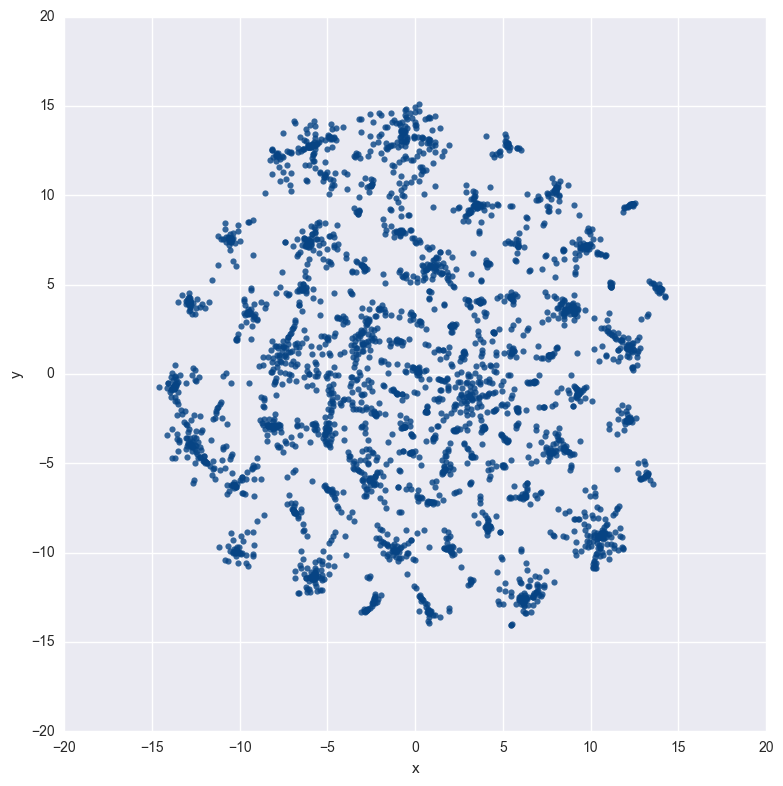

In [15]:
sns.lmplot("x", "y", data=count_idf_tsne_df, fit_reg=False, aspect=1.0, size=8, scatter_kws={"color": "#074484"})

In [16]:
clusters_idf = get_clusters(dtm_idf, sample_text_new.index, 7)
count_idf_tsne_df["Cluster"] = clusters_idf

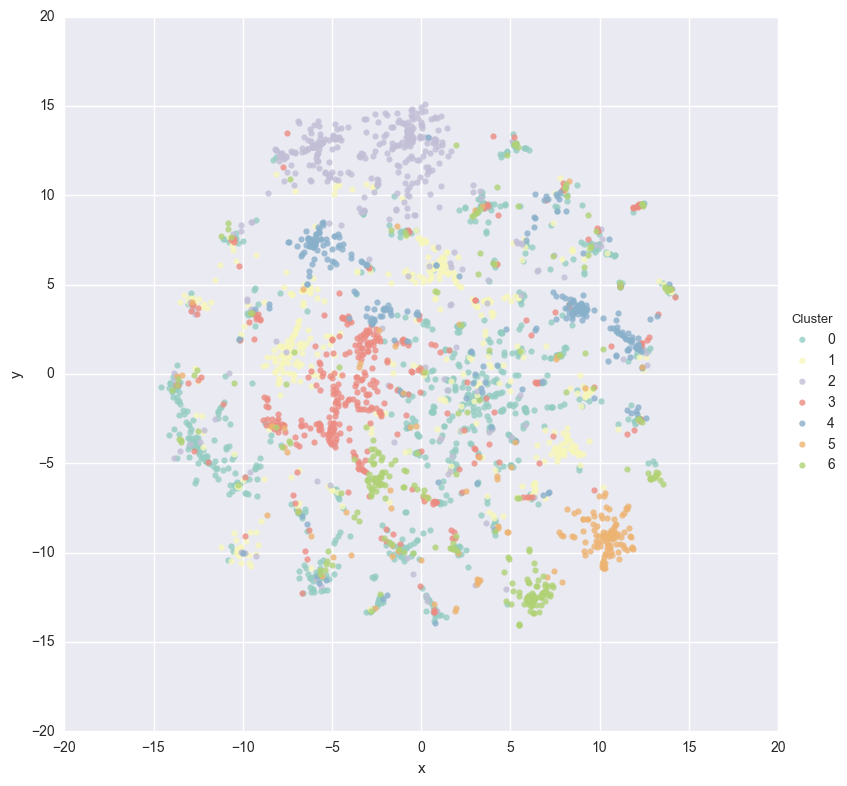

In [17]:
sns.lmplot("x", "y", data=count_idf_tsne_df, hue="Cluster", fit_reg=False, aspect=1.0, size=8)

In [18]:
sample_text_new_cluster = sample_text_new.join(pd.DataFrame(count_idf_tsne_df["Cluster"]), how="left")

In [19]:
sample_text_new_cluster["Cluster"].value_counts()

0    988
1    510
3    396
2    380
6    269
4    268
5    189
Name: Cluster, dtype: int64